# Summary of Steps taken and performance achieved

1. Linear Regression with no regularization
2. Ridge and Lasso
3. Gradient Boosting
4. Random Forest
5. XGboost

# Data

In [3]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge,LassoCV, Lasso, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.svm import SVR
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_validate #Additional scklearn functions
from sklearn.model_selection import cross_val_score
from matplotlib.pylab import rcParams

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [190]:
df = pd.read_csv("/content/drive/MyDrive/MSML/Concrete/DATASET/domestic.csv",encoding='cp949')
df = df.drop(columns=['slag','ash', 'age']) # slag, ash

In [130]:
df.isnull().sum()

cement          0
water           0
superplastic    0
coarseagg       0
fineagg         0
strength        0
dtype: int64

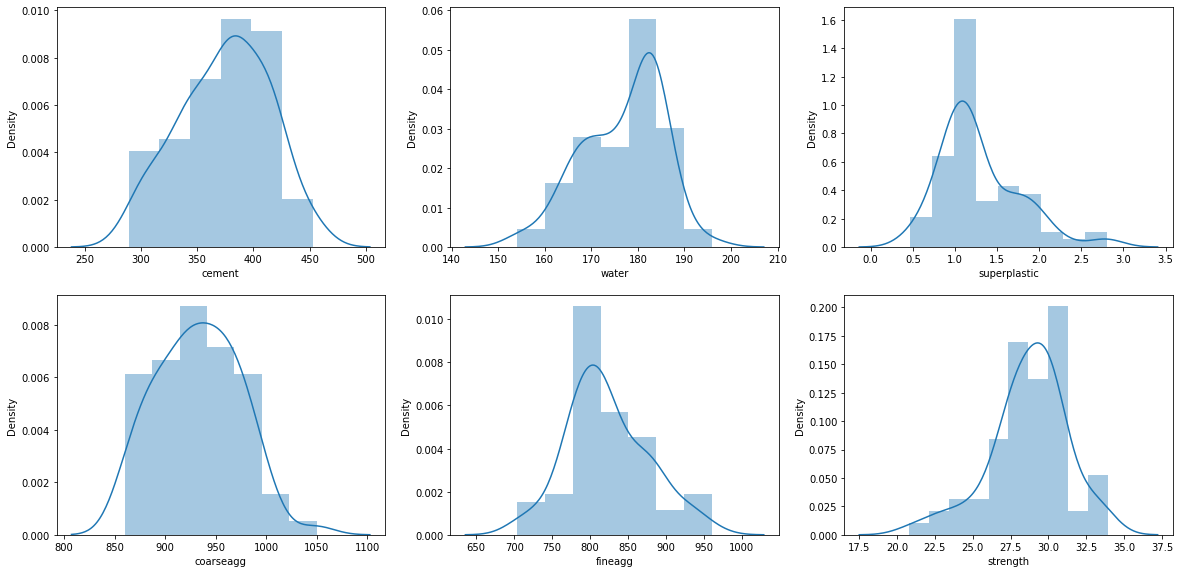

In [132]:
var=np.arange(1,len(df.columns)+1)
var
from IPython.core.pylabtools import figsize
figsize(20, 15)
for i in var:
    plt.subplot(3,3,i)
    sns.distplot(df.iloc[:,(i-1)])

## Outliers

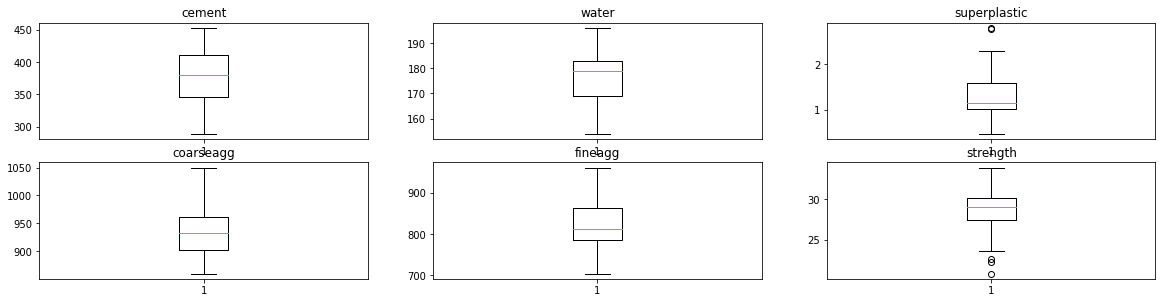

In [133]:
figsize(20, 15)
for i in var:
    plt.subplot(6,3,i)
    plt.boxplot(df.iloc[:,(i-1)])
    plt.title(df.columns[i-1])

A few variables a have some outliers. There are various methods of treating outliers. In this case, I am capping the outliers to the maximum possible value that is not an outlier.

In [134]:
Q1=np.percentile(df['superplastic'],25)
Q3=np.percentile(df['superplastic'],75)
IQR=Q3-Q1
UL=Q3+1.5*IQR
df.superplastic=np.where(df.superplastic>UL, UL, df.superplastic)

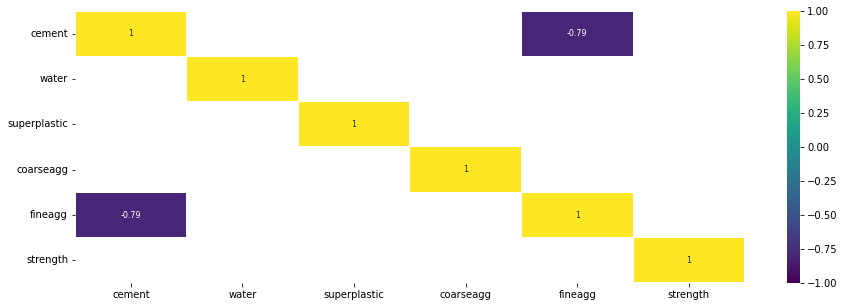

In [135]:
corr=df.corr()
plt.figure(figsize=(15, 5))
sns.heatmap(corr[(corr >= 0.70) | (corr <= -0.70)], 
            cmap='viridis', vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot=True, annot_kws={"size": 8})

This corrrealtion is theoretically meaningless, so I will ignore it for now.

## Clustering, 샘플을 n개로 군집화

#### Elbow Method

Cluster 간의 거리의 합을 나타내는 inertia가 급격히 떨어지는 구간이 생기는데 이 지점의 K 값을 군집의 개수로 사용. inertia_속성으로 확인 할 수 있다.

In [136]:
from sklearn.cluster import KMeans

In [138]:
cl=np.arange(1,9)  # k_range
ess=[]   # ineretia_
for i in cl:
    clust=KMeans(n_init=15,n_clusters=i)
    clust.fit(df.iloc[:,0:5])
    error=clust.inertia_
    ess.append(error)

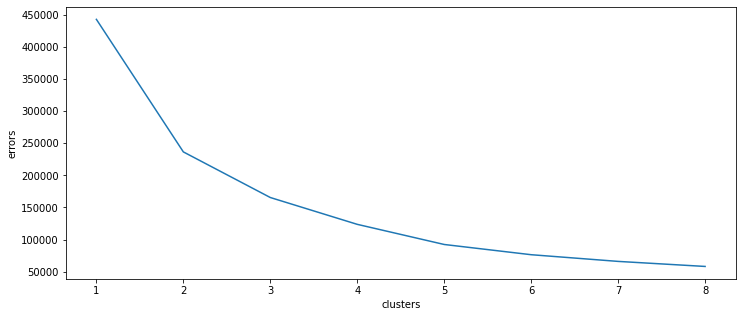

In [139]:
a=pd.DataFrame({'clusters':cl, 'errors':ess})
plt.figure(figsize=(12,5))
sns.lineplot(a.clusters, a.errors)

(1) At 2 clusters, elbow is seen.

In [140]:
clust=KMeans(n_init=15, n_clusters=2)
clust.fit(df.iloc[:,0:5])
df['cluster']=clust.predict(df.iloc[:,0:5])
df.cluster=pd.Categorical(df.cluster)

In [141]:
df.cluster.value_counts() , df.columns

(1    50
 0    22
 Name: cluster, dtype: int64,
 Index(['cement', 'water', 'superplastic', 'coarseagg', 'fineagg', 'strength',
        'cluster'],
       dtype='object'))

In [143]:
X=df.iloc[:,[0,1,2,3,4,6]].values
y=df.strength.values

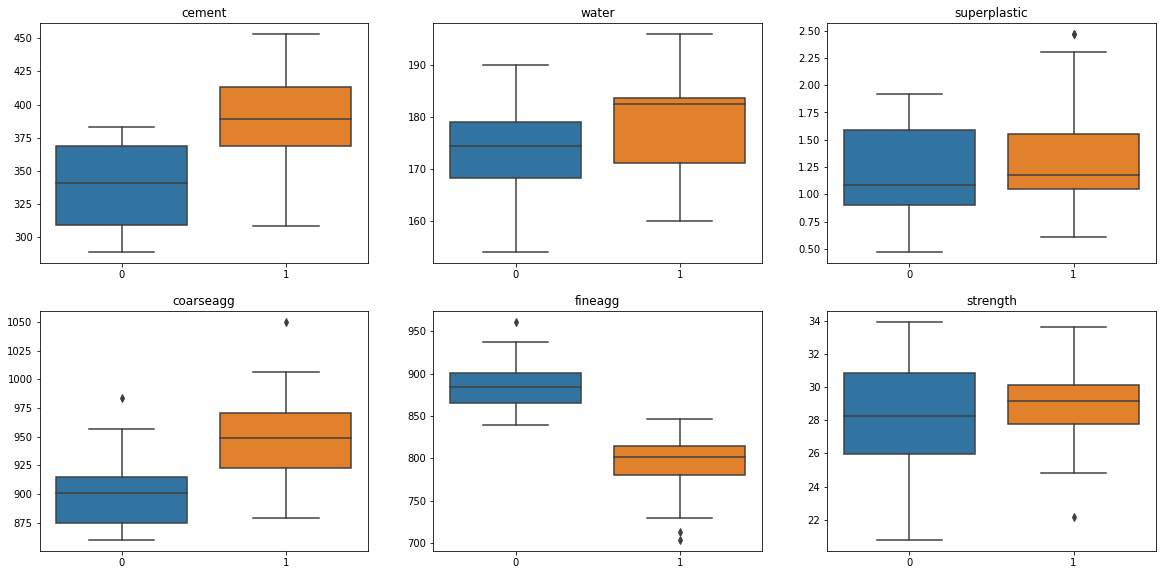

In [144]:
var=np.arange(1,len(df.columns))
var
from IPython.core.pylabtools import figsize
figsize(20, 15)
for i in var:
    plt.subplot(3,3,i)
    sns.boxplot(df.iloc[:,6],df.iloc[:,(i-1)])
    plt.xlabel("")
    plt.ylabel("")
    plt.title(df.columns[i-1])

**There seems to be three distinct clusters, especially when we see the distribution for strength of cement.**

---




There are a few more outliers when the distribution seen for each cluster which we may or may not want to treat depending on our model performances.

#### We check below the performance of models with addition of the new variable i.e. cluster

In [145]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [146]:
def test(models, X,y, iterations = 100):  # train/test set으로 나누고, model로 훈련시킨 후, 예측, 점수 계산하는 메소드
    results = {}
    for i in models:
        r2_train = []
        r2_test = []
        for j in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(X,y,test_size= 0.2,random_state=1)
            r2_test.append(r2_score(y_test,
                                            models[i].fit(X_train, 
                                                         y_train).predict(X_test)))
            r2_train.append(r2_score(y_train, 
                                             models[i].fit(X_train, 
                                                          y_train).predict(X_train)))
        results[i] = [np.mean(r2_train), np.mean(r2_test)]
    return pd.DataFrame(results)

In [147]:
models = {'OLS': LinearRegression(),
         'Lasso': Lasso(),
         'Ridge': Ridge()}

test(models, X,y)

,OLS,Lasso,Ridge
0,0.535191,0.422923,0.531407
1,0.191869,0.446457,0.279251


Hyperparameter Tuning / Regularization introduced

In [148]:
lasso_params = {'alpha':[0.02, 0.024, 0.025, 0.026, 0.03]}
ridge_params = {'alpha':[200, 230, 250,265, 270, 275, 290, 300, 500]}

models2 = {'OLS':LinearRegression(),
           'Lasso': GridSearchCV(Lasso(),param_grid=lasso_params, cv=10).fit(X,y).best_estimator_,
           'Ridge': GridSearchCV(Ridge(), 
                               param_grid=ridge_params, cv=10).fit(X, y).best_estimator_,}

test(models2, X,y)

,OLS,Lasso,Ridge
0,0.535191,0.533951,0.435113
1,0.191869,0.242343,0.456538


#### Try the models without the new variable

In [149]:
X=df.iloc[:,0:5].values
y=df.strength.values

models = {'OLS': LinearRegression(),
         'Lasso': Lasso(),
         'Ridge': Ridge()}

test(models, X,y)

,OLS,Lasso,Ridge
0,0.451703,0.422923,0.451523
1,0.430672,0.446457,0.437480


No major difference observed with regularization. Also the addition of cluster did not improve the results.

## So proceeding with the new column

In [375]:
X=df.iloc[:,0:5].values
y=df.strength.values
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)

#### Ridge

In [376]:
param_grid={'alpha':[0.001,0.1,0.5,1,2.5,5,10]}
Rid=Ridge()
Rid_gs=GridSearchCV(Rid,param_grid, cv=10, scoring='neg_mean_squared_error')
Rid_gs.fit(X_train,y_train)
Rid_gs.best_estimator_

Ridge(alpha=5)

In [377]:
print(Rid_gs.best_score_)
print("Train Rsq:%.2f" %r2_score(y_train,Rid_gs.predict(X_train)))
print("Test Rsq:%.2f" %r2_score(y_test,Rid_gs.predict(X_test)))
print()
print("Correlation_Test:", np.corrcoef(y_test,Rid_gs.predict(X_test))[0,1])

-4.741850699385807
Train Rsq:0.45
Test Rsq:0.45

Correlation_Test: 0.784641532154518


In [378]:
Rid_gs.best_estimator_.coef_

array([-0.00503615, -0.27973153,  0.50215037, -0.05861027, -0.0593906 ])

Text(0.5, 1.0, 'Actuals v Predicted')

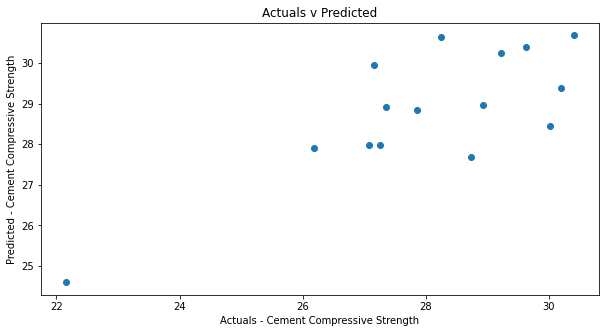

In [379]:
plt.figure(figsize=(10,5))
plt.scatter(y_test, Rid_gs.predict(X_test))
plt.xlabel("Actuals - Cement Compressive Strength")
plt.ylabel("Predicted - Cement Compressive Strength")
plt.title("Actuals v Predicted")

#### Lasso

In [380]:
param_grid={'alpha':[0.001,0.1,0.5,1,2.5,5,10]}
Las=Lasso()
Las_gs=GridSearchCV(Las,param_grid, cv=10, scoring='neg_mean_squared_error')
Las_gs.fit(X_train,y_train)
Las_gs.best_estimator_

Lasso(alpha=0.001)

In [381]:
print(Las_gs.best_score_)
print("Train Rsq:%.2f" %r2_score(y_train,Las_gs.predict(X_train)))
print("Test Rsq:%.2f" %r2_score(y_test,Las_gs.predict(X_test)))
print()
print("Correlation_Test:", np.corrcoef(y_test,Las_gs.predict(X_test))[0,1])

-4.772958337191648
Train Rsq:0.45
Test Rsq:0.43

Correlation_Test: 0.7751546160591066


In [382]:
Las_gs.best_estimator_.coef_

array([-0.00717821, -0.27639964,  0.77968915, -0.05978246, -0.06035955])

## Attempt to fit models by transforming the input variables to higher dimension

Try with polynomial

In [383]:
from sklearn.preprocessing import PolynomialFeatures

poly=PolynomialFeatures(degree=2)

X_train_tr=poly.fit_transform(X_train)
X_test_tr=poly.fit_transform(X_test)

#### Ridge

In [384]:
param_grid={'alpha':[0.1,0.5,1,2.5,5,10,20,30,35,36,37,38,39,40,41,42,43,45]}
Rid=Ridge()
Rid_gs=GridSearchCV(Rid,param_grid, cv=10, scoring='neg_mean_squared_error')
Rid_gs.fit(X_train_tr,y_train)
Rid_gs.best_estimator_

print(Rid_gs.best_score_)
print("Train Rsq:%.2f" %r2_score(y_train,Rid_gs.predict(X_train_tr)))
print("Test Rsq:%.2f" %r2_score(y_test,Rid_gs.predict(X_test_tr)))
print()
print("Correlation_Test:", np.corrcoef(y_test,Rid_gs.predict(X_test_tr))[0,1])

-6.609828153865938
Train Rsq:0.61
Test Rsq:-0.28

Correlation_Test: 0.46512895966108153


Result is worse than original dimension.

# Machine Learning (Ensemble)

## Boosting

In [386]:
predictors=df.drop(['strength'], axis=1).columns
predictors

Index(['cement', 'water', 'superplastic', 'coarseagg', 'fineagg'], dtype='object')

In [391]:
def modelfit(alg, dtrain, dtest, printFeatureImportance=True, cv_folds=10):
    #Fit the algorithm on the data
    alg.fit(X_train, y_train)

    #Predict training set:
    dtrain_predictions = alg.predict(X_train)    

    #Predict test set:
    dtest_predictions = alg.predict(X_test)        
    
    #Print model report:
    print("\nModel Report")
    print("Rsq (Train): %.4g" % r2_score(y_train, dtrain_predictions))
    print("Rsq (Test): %.4g" % r2_score(y_test, dtest_predictions))
    print("\n")
        
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(alg.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')


Model Report
Rsq (Train): 0.9943
Rsq (Test): 0.5241




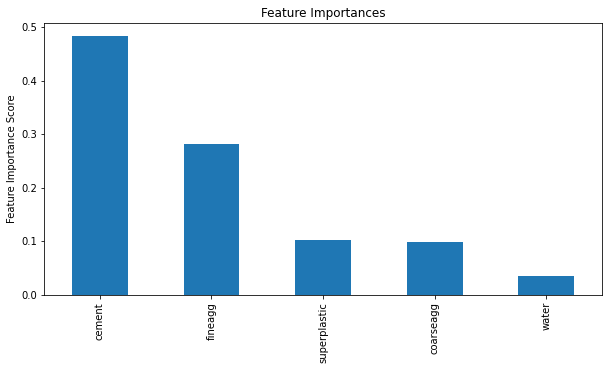

In [426]:
from sklearn.ensemble import GradientBoostingRegressor
gbr=GradientBoostingRegressor(random_state=False)

plt.figure(figsize=(10,5))
modelfit(gbr, X_train, X_test)

#### Parameter Tuning.

Boosting 파라미터
*   n_estimators(트리 수), 훈련을 제어하는 변수 : {'n_estimators':range(20,150,10)}
*   max_depth, 성장을 제어하는 변수 : {'max_depth':range(5,16,2)}
*   min_samples_split : {'min_samples_split':range(10,100,10)}
*   max_features : {'max_features':range(2,5,1)}


## Random Forest

RandomForest 파라미터
*   {'n_estimators':range(20,150,10)}
*   {'max_depth':range(4,16,2)}
*   {'min_samples_split':range(10,100,10)}
*   {'max_features':range(3,7,1)}


Model Report
Rsq (Train): 0.9205
Rsq (Test): 0.4987




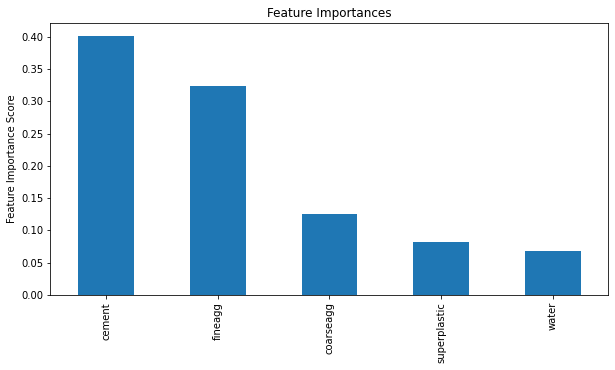

In [481]:
Rf= RandomForestRegressor(random_state=False, n_estimators = 100)

plt.figure(figsize=(10,5))
modelfit(Rf, X_train, X_test)

## XGBoost

In [487]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

X=df.iloc[:,0:5].values
y=df.strength.values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2,random_state=1)

predictors = ['cement', 'water', 'superplastic', 'coarseagg','fineagg']  

In order to decide on boosting parameters, we need to set some initial values of other parameters.

[13:46:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Model Report
Rsq (Train): 1
Rsq (Test): 0.5297




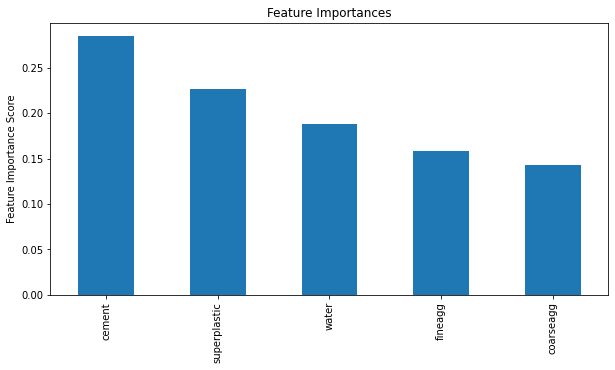

In [488]:
xgb1 = XGBRegressor(booster='gbtree',
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 nthread=4,
 scale_pos_weight=1,
 seed=27)

plt.figure(figsize=(10,5))
modelfit(xgb1, X_train,X_test, predictors)

### Hyperparameter Tuning

#### Tune max_depth and min_child_weight

In [521]:
param_test1 = {
 'max_depth':range(3,8,1),
 'min_child_weight':range(1,6,1)
}

gsearch1 = GridSearchCV(estimator = XGBRegressor( booster='gbtree', learning_rate =0.1, n_estimators=100,
                                                  gamma=0, subsample=0.8, colsample_bytree=0.8,
                                                  nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test1, scoring='neg_mean_squared_error',n_jobs=4, cv=5)

gsearch1.fit(X_train,y_train)
gsearch1.best_params_, gsearch1.best_score_

[14:00:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'max_depth': 5, 'min_child_weight': 6}, -5.036763836801067)

[14:00:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Model Report
Rsq (Train): 0.9247
Rsq (Test): 0.7156




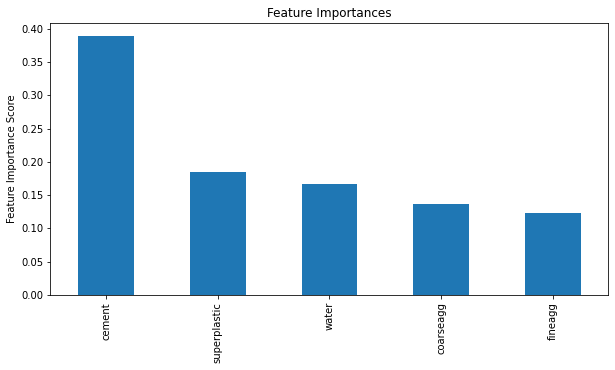

In [522]:
plt.figure(figsize=(10,5))
modelfit(gsearch1.best_estimator_, X_train, X_test, predictors)

In [496]:
param_test2 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch2 = GridSearchCV(estimator = XGBRegressor(booster='gbtree', learning_rate =0.1, n_estimators=100,
                                                 max_depth=3, min_child_weight=4,
                                                 nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test2, scoring='neg_mean_squared_error',n_jobs=4,cv=5)
gsearch2.fit(X_train,y_train)
gsearch2.best_params_, gsearch1.best_score_

[13:48:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'reg_alpha': 1}, -4.671299928283342)

[13:48:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Model Report
Rsq (Train): 0.9396
Rsq (Test): 0.707




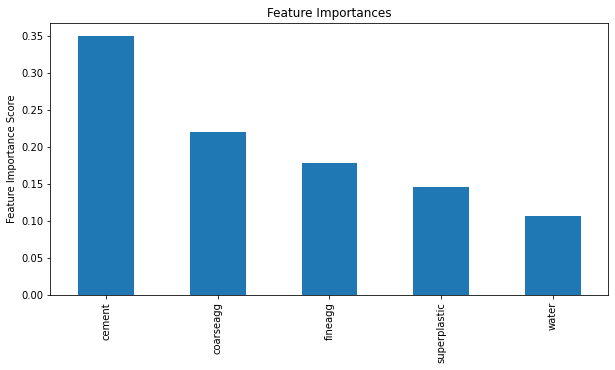

In [497]:
plt.figure(figsize=(10,5))
modelfit(gsearch2.best_estimator_, X_train, X_test, predictors)

Fine Tuning

In [511]:
param_test3 = {
 'reg_alpha':[0.8, 0.9, 1, 1.2, 1.3, 1.4, 1.5, 2]
}

gsearch3 = GridSearchCV(estimator = XGBRegressor( booster='gbtree', learning_rate =0.1, n_estimators=100,
                                                  max_depth=3, min_child_weight=4,
                                                  nthread=4, scale_pos_weight=1, seed=27), 
                        param_grid = param_test3, scoring='neg_mean_squared_error',n_jobs=4,cv=5)
gsearch3.fit(X_train,y_train)
gsearch3.best_params_, gsearch1.best_score_

[13:54:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


({'reg_alpha': 1.5}, -4.671299928283342)

[13:54:46] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Model Report
Rsq (Train): 0.926
Rsq (Test): 0.7414




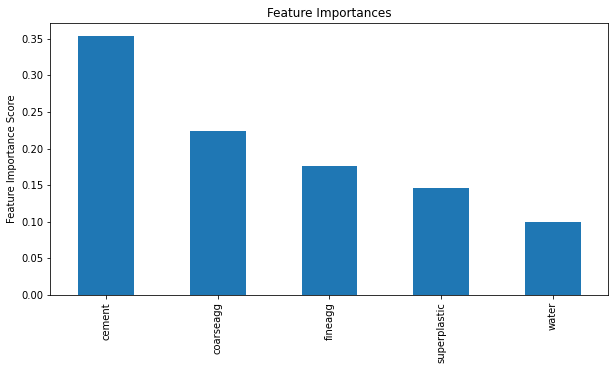

In [512]:
plt.figure(figsize=(10,5))
modelfit(gsearch3.best_estimator_, X_train, X_test, predictors)

In [523]:
XGB= XGBRegressor(booster='gbtree', learning_rate =0.1, n_estimators=100,
                  max_depth=3, min_child_weight=4,
                  reg_alpha=1.5, 
                  nthread=4, scale_pos_weight=1, seed=27)

[14:01:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.

Model Report
Rsq (Train): 0.926
Rsq (Test): 0.7414




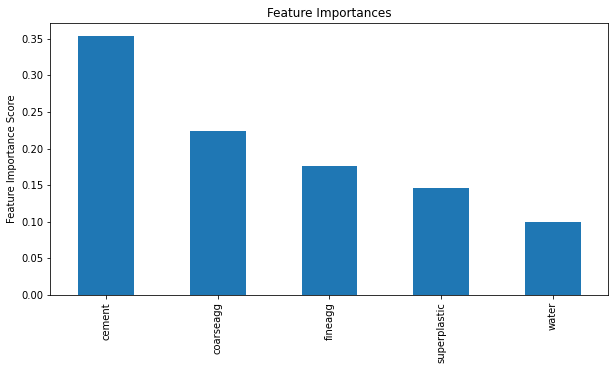

In [524]:
plt.figure(figsize=(10,5))
modelfit(XGB, X_train, X_test, predictors)

XGB is the final model.

Text(0.95, 0.14, 'Train : $R^2$ =0.926\nTest: $R^2$ =0.741')

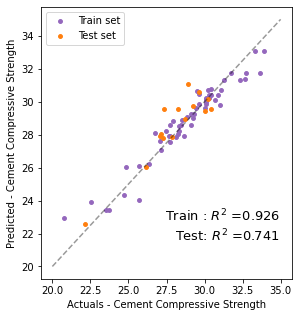

In [551]:
fig, ax = plt.subplots(figsize=(4.5,5))

ax.scatter(y_train, XGB.predict(X_train), color='C4', label='Train set', s=15)
ax.scatter(y_test, XGB.predict(X_test), color='C1', label='Test set', s=15)

ax.set_xlabel("Actuals - Cement Compressive Strength")
ax.set_ylabel("Predicted - Cement Compressive Strength")
ax.legend(loc='upper left')

# y=x dashed line
ax.plot([20,35], [20,35], c="k", linestyle='--',alpha=0.4)

ax.text(0.95, 0.14, f"Train : $R^2$ ={r2_score(y_train,XGB.predict(X_train)):0.3f}\nTest: $R^2$ ={r2_score(y_test, XGB.predict(X_test)):0.3f}",
        transform=ax.transAxes, fontsize=13, ha="right")

In [552]:
df.strength.describe()

count    72.000000
mean     28.689583
std       2.578204
min      20.790000
25%      27.435000
50%      29.030000
75%      30.200000
max      33.930000
Name: strength, dtype: float64

In [553]:
len(df)

72

## Trial

In [543]:
input = pd.DataFrame(columns=df.iloc[:,0:5].columns)
input.loc[0] = [550, 148, 12.1, 1056, 700]
input

,cement,water,superplastic,coarseagg,fineagg
0,550.0,148.0,12.1,1056.0,700.0


In [544]:
XGB.predict(input)

array([29.536282], dtype=float32)